<a href="https://colab.research.google.com/github/Inteli-College/2024-2A-T01-CC11-G04/blob/29-implementao-de-modelo-com-rede-neural-word2vec/notebooks/sprint2/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependências

In [44]:
import os
import logging
import zipfile
import requests
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Modelo Word2Vec

Nesta seção, é apresentada a classe Word2VecModel, que encapsula a funcionalidade do modelo Word2Vec, permitindo o download, carregamento e interação com o modelo usando uma lista de vocabulário. A classe oferece métodos para obter o tamanho do vocabulário, encontrar palavras mais semelhantes, e recuperar vetores de palavras específicas.

In [45]:
"""
Word2Vec Model Module

This module provides functionality to download, load, and interact with a Word2Vec model using a given vocabulary list.
It includes methods to get the vocabulary size, find the most similar words, and retrieve word vectors.

Classes:
--------
Word2VecModel
    A class to encapsulate the functionality of the Word2Vec model using a vocabulary list.

Functions:
----------
test_word2vec_model
    Tests the Word2VecModel class.
"""

# Logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Word2VecModel:
    """
    A class to encapsulate the functionality of the Word2Vec model using a vocabulary list.

    Attributes:
    -----------
    model : KeyedVectors
        The loaded Word2Vec model.
    vocab : list
        The vocabulary list.
    """

    def __init__(self, vocab):
        """
        Initializes the Word2VecModel class with a vocabulary list.

        Parameters:
        -----------
        vocab : list
            The vocabulary list.
        """
        self.vocab = vocab
        self.model = self._load_model()

    def _download_and_extract_model(self, url, extract_to='.'):
        """
        Downloads and extracts the Word2Vec model.

        Parameters:
        -----------
        url : str
            The URL of the zip file containing the Word2Vec model.
        extract_to : str
            The directory to extract the zip file to.
        """
        local_zip_file = "w2v.vectors.zip"

        logging.info(f"Downloading the model from {url}...")
        # Download the zip file
        response = requests.get(url)
        with open(local_zip_file, 'wb') as f:
            f.write(response.content)

        logging.info("Extracting the zip file...")
        # Extract the zip file
        with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        logging.info("Model downloaded and extracted successfully.")

    def _load_model(self):
        """
        Loads the Word2Vec model from a temporary file.

        Returns:
        --------
        KeyedVectors
            The loaded Word2Vec model.
        """
        model_dir = os.path.join(os.getcwd(), 'models')
        model_file = os.path.join(model_dir, 'w2v.vectors.kv')

        if not os.path.exists(model_file):
            os.makedirs(model_dir, exist_ok=True)
            self._download_and_extract_model(
                'https://github.com/rdenadai/WordEmbeddingPortugues/releases/download/0.5/w2v.vectors.zip',
                extract_to=model_dir
            )

        logging.info("Loading the Word2Vec model...")
        model = KeyedVectors.load(model_file, mmap='r')
        logging.info("Model loaded successfully.")
        return model

    def get_vocab_size(self):
        """
        Returns the size of the vocabulary.

        Returns:
        --------
        int
            The size of the vocabulary.
        """
        return len(self.vocab)

    def most_similar(self, word, topn=3):
        """
        Finds the most similar words for a given word.

        Parameters:
        -----------
        word : str
            The word to find the most similar words for.
        topn : int, optional
            The number of most similar words to return (default is 3).

        Returns:
        --------
        list of tuples
            A list of tuples containing the most similar words and their similarities.
        """
        return self.model.most_similar(word, topn=topn)

    def display_similar_words(self, words, topn=3):
        """
        Displays the most similar words for a given list of words.

        Parameters:
        -----------
        words : list
            The list of words to find the most similar words for.
        topn : int, optional
            The number of most similar words to return (default is 3).
        """
        for word in words:
            print(f"\n{word}:")
            print("-" * 28)
            similar_words = self.most_similar(word, topn=topn)
            for similar_word, similarity in similar_words:
                print(f"{similar_word:<20} {similarity:.5f}")

    def get_vector(self, word):
        """
        Returns the vector for a given word.

        Parameters:
        -----------
        word : str
            The word to get the vector for.

        Returns:
        --------
        numpy.ndarray
            The vector corresponding to the given word.
        """
        if word in self.model:
            return self.model[word]
        else:
            logging.warning(f"The word '{word}' is not in the vocabulary.")
            return None

## Testes

Aqui, é realizada a validação da classe Word2VecModel através de testes automatizados que verificam o tamanho do vocabulário, a funcionalidade de encontrar palavras semelhantes, e a recuperação de vetores de palavras. Estes testes garantem que a implementação está correta antes de prosseguir.

In [46]:
# Automated tests
def test_word2vec_model():
    """
    Tests the Word2VecModel class.
    """
    # Example vocabulary list
    vocab = [
        "preto", "branco", "pássaro", "lobo", "mulher",
        "masculino", "sexo", "montanha", "oceano", "lua",
        "amor", "senhor", "cimegripe", "nimesulida", "médico",
        "doença", "coração", "febre", "dor", "coriza",
        "rancor", "mau", "ódio", "braço", "maçã", "coco",
        "lobo mau", "espada", "cavaleiro", "rei", "arthur",
        "rei arthur"
    ]

    # Initialize the model
    w2v_model = Word2VecModel(vocab)

    # Test vocabulary size
    assert w2v_model.get_vocab_size() == len(vocab), "Vocabulary size should match the number of words in the list"

    # Test most_similar function
    similar_words = w2v_model.most_similar("preto")
    assert len(similar_words) == 3, "Should return 3 most similar words"

    # Test get_vector function
    vector = w2v_model.get_vector("preto")
    assert vector is not None, "Vector for the word 'preto' should not be None"
    assert isinstance(vector, np.ndarray), "Vector should be an instance of numpy.ndarray"

    print("All tests passed successfully!")

# Run tests
test_word2vec_model()

All tests passed successfully!


## Exemplos
Esta seção apresenta exemplos práticos de como utilizar a classe Word2VecModel para realizar operações comuns, como obter o vetor de uma palavra específica e exibir as palavras mais semelhantes dentro do vocabulário fornecido.

In [47]:
# Example vocabulary list
vocab = [
    "preto", "branco", "pássaro", "lobo", "mulher",
    "masculino", "sexo", "montanha", "oceano", "lua",
    "amor", "senhor", "cimegripe", "nimesulida", "médico",
    "doença", "coração", "febre", "dor", "coriza",
    "rancor", "mau", "ódio", "braço", "maçã", "coco",
    "lobo mau", "espada", "cavaleiro", "rei", "arthur",
    "rei arthur"
]

# Initialize the model
w2v_model = Word2VecModel(vocab)

## Vetor para uma palavra específica

In [48]:
word = "preto"
vector = w2v_model.get_vector(word)
if vector is not None:
    print(f"\nVector for the word '{word}':")
    print(vector)


Vector for the word 'preto':
[-0.18456692  0.45947403 -0.3821056  -0.02077596 -0.23175432  0.07987644
 -0.3943945   0.76432955  0.46100053 -0.42329612  0.10303371 -0.5554464
 -0.02964008  0.46156192 -0.33882576  0.5367816  -0.37528178  0.3743576
 -0.33563468  0.06717291 -0.3518185  -0.33390772  0.3943198  -0.11014716
  0.35076675  0.20479676 -0.21331453  0.5136635   0.04756886  0.01480213
 -0.18874457 -0.019419    0.02637832 -0.15573753 -0.46401948 -0.4600487
  0.45187503 -0.77291965  0.5112315  -0.40727443  0.36893058 -0.50125456
  0.29415026  0.27494213 -0.12086222 -0.5641251   0.22782342 -0.04439939
 -0.5548213  -0.12074754  0.4284054   0.20094873  0.28850272 -0.15562855
 -0.44299254  0.03049284 -0.2979641   0.11766719 -0.11960624 -0.01153767
  0.35770217 -0.2530105  -0.91969466 -0.48409802 -0.00895272  0.1177898
 -0.44785565 -0.57226074  0.4965827  -0.14205226  0.07649645  0.07154312
  0.08092815 -0.13254258  0.51889384  0.248033    0.19830738 -0.12169341
 -0.02046384 -0.0416936  

## Palavras mais similares

In [49]:
w2v_model.display_similar_words(["preto", "branco", "pássaro", "lobo", "mulher"])


preto:
----------------------------
branco               0.79271
dourado              0.75473
cinza                0.75170

branco:
----------------------------
branca               0.79388
preto                0.79271
roxo                 0.75019

pássaro:
----------------------------
pássaros             0.77602
rouxinol             0.76595
hipopótamo           0.76495

lobo:
----------------------------
lobos                0.68262
grilo                0.67680
cervo                0.65533

mulher:
----------------------------
homem                0.81129
menina               0.78433
mulheres             0.78332


## Número de tokens no modelo

In [50]:
print(f"Tokens: {len(w2v_model.model.key_to_index)}")

Tokens: 981032


## Processamento de Banco de Dados
Nesta parte, os dados são carregados e processados, incluindo a codificação das intenções (intention) com LabelEncoder e a aplicação de vetorização às perguntas processadas. Esta etapa é essencial para preparar os dados antes de alimentá-los na rede neural.

In [51]:
# Load the data
path_database = "/content/processed_data.xlsx"
df = pd.read_excel(path_database)

# Label Encoding of the 'intention' column
label_encoder = LabelEncoder()
df['intention_encoded'] = label_encoder.fit_transform(df['intention'])

# Drop the original 'intention' and 'question' columns from the DataFrame
df = df.drop(columns=['intention', 'question'])

## Aplicando o formato em "question_embeddings"

In [52]:
# Assuming 'processed_question' and 'intention_encoded' are columns in the DataFrame
vocab = df['processed_question'].str.split(',').explode().unique().tolist()
word2vec_model = Word2VecModel(vocab)

# Function with purpose on call the pre trained model and apply vectorization over the all words
# After that, it will be take the mean of embeddings that represent words that build a sentence
def get_word2vec_embeddings(text):
    if isinstance(text, str):
        embeddings = [word2vec_model.get_vector(word) for word in text.split(',') if word2vec_model.get_vector(word) is not None]
        return np.mean(embeddings, axis=0) if embeddings else np.zeros(word2vec_model.model.vector_size)
    else:
        return np.zeros(word2vec_model.model.vector_size)

# Apply the function to the 'processed_question' column
df['question_embeddings'] = df['processed_question'].apply(get_word2vec_embeddings)

# Modelo de rede neural

## Divisão de Dados para Treinamento e Teste
Nesta seção, os dados divididos aleatoriamente em conjuntos de treinamento e teste. Esta divisão é crucial para avaliar o desempenho do modelo de forma justa, garantindo que o modelo seja treinado e testado em dados diferentes.

In [53]:
# Shuffle of data
df = shuffle(df, random_state=42)

# Preparing data for neural network
X = np.array(df['question_embeddings'].tolist())
y = to_categorical(df['intention_encoded'])

# Split the data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##  Técnicas de Regularização

Foi aplicada a técnica de regularização do "Early Stopping", ou seja, para evitar o overfitting foi dito que se a "val_loss" não diminuir até 10 épocas o treino será parado imediatamente.

Na célula seguinte, foi adicionado o "Dropout" para poder melhorar a generalização dos neurônios.

In [54]:
# Initialize EarlyStopping callback to prevent overfitting during training
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor the validation loss to determine when to stop training
    patience=10,                  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,    # Restore model weights from the epoch with the best validation loss
    start_from_epoch=10           # Start monitoring after the 10th epoch (useful for skipping initial epochs)
)

## Construção do Modelo
Criação de modelo usando somente redes densas totalmente conectadas. É importante enfatizar que a intenção foi simplificar para atingir altos resultados.

In [55]:
# Create the Sequential model
model = Sequential()

# Add a dense layer with 128 units and ReLU activation
model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
# Add a Dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))
# Add a Dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add an output layer with units equal to the number of classes and softmax activation
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Treinamento do Modelo
Aqui, o modelo de rede neural é treinado usando os dados de treinamento preparados anteriormente. Durante o treinamento, o modelo é avaliado continuamente nos dados de teste para monitorar seu desempenho e prevenir overfitting.

In [56]:
# Train the model with the training data
history = model.fit(
    X_train,          # Input data for training
    y_train,                 # Target labels for training
    epochs=5,              # Number of epochs to train the model
    batch_size=32,           # Number of samples per gradient update
    validation_data=(X_test, y_test),  # Data to evaluate the model during training
    callbacks=[early_stopping]  # List of callbacks to apply during training (e.g., early stopping)
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(
    X_test,  # Input data for evaluation
    y_test          # Target labels for evaluation
)

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.0988 - loss: 2.8350 - val_accuracy: 0.3662 - val_loss: 2.6499
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2014 - loss: 2.6527 - val_accuracy: 0.4648 - val_loss: 2.3452
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2877 - loss: 2.3829 - val_accuracy: 0.4986 - val_loss: 2.0184
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3699 - loss: 2.1114 - val_accuracy: 0.5803 - val_loss: 1.7574
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4183 - loss: 1.9560 - val_accuracy: 0.6507 - val_loss: 1.5531
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6758 - loss: 1.5394 


## Testes
Após o treinamento, são realizados testes adicionais para verificar a precisão das previsões do modelo em amostras do conjunto de teste. Esta seção ajuda a entender como o modelo está se comportando em termos de previsão correta ou incorreta.

In [57]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = np.argmax(y_test, axis=1)

# Counter for passed tests
num_tests_passed = 0
num_samples_to_show = 5

# Display some samples for verification
for i in range(num_samples_to_show):
    print(f"Sample {i+1}:")
    print(f"True class: {true_classes[i]}")
    print(f"Predicted class: {predicted_classes[i]}")

    # Check if the prediction is correct
    if predicted_classes[i] == true_classes[i]:
        print("Test Passed")
        num_tests_passed += 1
    else:
        print("Test Failed")
    print()

# Display the total number of passed tests
total_samples = num_samples_to_show
print(f"Total number of tests passed: {num_tests_passed}/{total_samples}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sample 1:
True class: 11
Predicted class: 11
Test Passed

Sample 2:
True class: 12
Predicted class: 15
Test Failed

Sample 3:
True class: 2
Predicted class: 2
Test Passed

Sample 4:
True class: 1
Predicted class: 1
Test Passed

Sample 5:
True class: 12
Predicted class: 12
Test Passed

Total number of tests passed: 4/5


## Métricas de avaliação

Nesta parte, são calculadas e discutidas as principais métricas de avaliação do modelo: acurácia, matriz de confusão, precisão, recall e F1-Score. Cada métrica fornece uma visão diferente sobre o desempenho do modelo.

In [58]:
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [59]:
y_pred_classes = (y_pred > 0.5).astype(int)

### Acurácia
A acurácia do modelo é de aproximadamente 79,44%. Isso significa que, em média, o modelo fez previsões corretas em cerca de 79% das vezes. Isso é uma boa indicação de que o modelo está, em geral, funcionando bem, mas ainda há espaço para melhorias..

In [60]:
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))
print(f'Acurácia do modelo: {accuracy:.4f}')

Acurácia do modelo: 0.2282


### Matriz de confusão
- **Predominância na Diagonal Principal:** A maioria dos valores está concentrada na diagonal principal da matriz, o que significa que o modelo está corretamente identificando a maioria das classes. Por exemplo, para a segunda classe, o modelo classificou corretamente 25 instâncias, sem erros.

- **Erros de Classificação:** Algumas classes têm valores fora da diagonal principal, o que indica erros de classificação. Por exemplo, a classe 2 teve 4 instâncias erroneamente classificadas como classe 0. Esses erros sugerem que o modelo confunde algumas classes específicas.

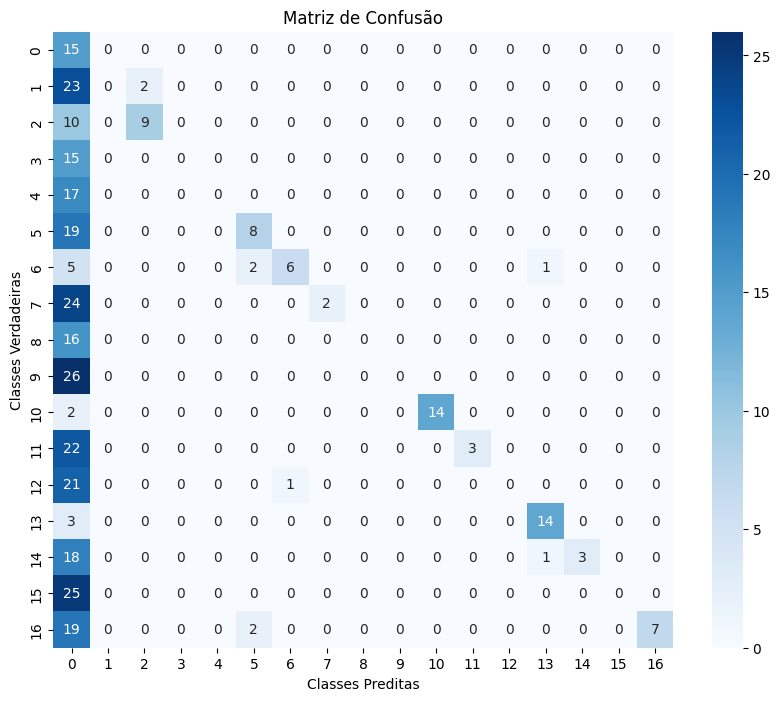

In [61]:
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_classes.argmax(axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classes Preditas')
plt.ylabel('Classes Verdadeiras')
plt.show()

### Precisão
A precisão de 90,12% é muito alta, o que significa que quando o modelo faz uma previsão positiva para uma determinada classe, 90% dessas previsões são corretas. Isso indica que o modelo é bom em evitar falsos positivos, ou seja, não classifica incorretamente instâncias de outras classes como pertencentes a uma classe específica.

In [62]:
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precisão: {precision:.4f}')

Precisão: 0.5420


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Recall
O recall de 79,44%, mostra que o modelo é capaz de identificar corretamente quase 80% das instâncias de cada classe. No entanto, ainda há 20% das instâncias verdadeiras que não foram identificadas corretamente (falsos negativos).

In [63]:
recall = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

Recall: 0.1887


### F1-Score
O F1-Score é 83,48%, que é um bom equilíbrio entre precisão e recall. Este valor indica que o modelo mantém um bom desempenho tanto em evitar falsos positivos quanto em capturar a maioria das instâncias corretas.

In [64]:
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1-Score: {f1:.4f}')

F1-Score: 0.2458


# Treinamento do Modelo com CPU e GPU
Este notebook tem como objetivo treinar um modelo de Machine Learning utilizando tanto a CPU quanto a GPU disponíveis no Google Colab e comparar o desempenho entre as duas alternativas.

## Instruções para Treinamento do Modelo
### Configuração do Ambiente
Verificação da GPU: Primeiro, verifique se a GPU estava ativada no ambiente Colab. Acesse: Ambiente de execução > Alterar tipo de ambiente de execução e selecione a GPU.

In [65]:
!pip install gputil

## Encapsular o modelo

Para facilitar as comparações posteriores, o modelo será encapsulado dentro de uma função em que podemos treinar, depois, com a CPU ou a GPU.

In [66]:
import tensorflow as tf
import time
import psutil
import GPUtil
import numpy as np
import matplotlib.pyplot as plt

In [73]:
# Função para treinar e avaliar o modelo, medindo tempo e uso de memória
def train_and_evaluate(X_train, y_train, X_test, y_test, device, epochs=25, batch_size=32, callbacks=None):
    """
    Treina e avalia um modelo de aprendizado de máquina, medindo o tempo total de treinamento, o tempo médio por época, e o uso de memória e CPU.
    Também avalia o modelo no conjunto de dados de teste e, se um dispositivo GPU estiver disponível, reporta o uso da GPU.

    Parâmetros:
    - X_train (np.ndarray ou tf.Tensor): Dados de entrada para treinamento.
    - y_train (np.ndarray ou tf.Tensor): Rótulos para os dados de treinamento.
    - X_test (np.ndarray ou tf.Tensor): Dados de entrada para avaliação.
    - y_test (np.ndarray ou tf.Tensor): Rótulos para os dados de avaliação.
    - device (str): Dispositivo no qual o treinamento deve ocorrer. Pode ser 'CPU' ou 'GPU'.
    - epochs (int, opcional): Número de épocas para treinamento (padrão é 25).
    - batch_size (int, opcional): Tamanho do lote para o treinamento (padrão é 32).
    - callbacks (list de tf.keras.callbacks.Callback, opcional): Lista de callbacks para usar durante o treinamento. Se None, apenas o callback de tempo é adicionado.

    Retorna:
    - history (tf.keras.callbacks.History): Histórico do treinamento, incluindo métricas de desempenho durante as épocas.
    - loss (float): Perda final do modelo no conjunto de teste.
    - accuracy (float): Precisão final do modelo no conjunto de teste.
    - epoch_times (list de float): Lista com o tempo gasto em cada época.
    """

    # Define o dispositivo para treinamento
    with tf.device(device):
        # Create the Sequential model
        model = Sequential()

        # Add a dense layer with 128 units and ReLU activation
        model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
        # Add a Dropout layer with a rate of 0.5
        model.add(Dropout(0.5))

        # Add a dense layer with 64 units and ReLU activation
        model.add(Dense(64, activation='relu'))
        # Add a Dropout layer with a rate of 0.5
        model.add(Dropout(0.5))

        # Add an output layer with units equal to the number of classes and softmax activation
        model.add(Dense(y_train.shape[1], activation='softmax'))

        # Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy metric
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Monitoramento de uso de memória e tempo
        process = psutil.Process()
        start_time = time.time()
        epoch_times = []

        # Callback para medir o tempo de cada época
        class TimeHistory(tf.keras.callbacks.Callback):
            def on_epoch_begin(self, epoch, logs=None):
                self.epoch_start_time = time.time()

            def on_epoch_end(self, epoch, logs=None):
                epoch_duration = time.time() - self.epoch_start_time
                epoch_times.append(epoch_duration)

        time_callback = TimeHistory()

        # Treinamento do modelo
        history = model.fit(
            X_train,              # Dados de entrada para treinamento
            y_train,              # Rótulos para os dados de treinamento
            epochs=epochs,        # Número de épocas para treinamento
            batch_size=batch_size,  # Tamanho do lote para treinamento
            validation_data=(X_test, y_test),  # Dados e rótulos para validação
            callbacks=[time_callback] if callbacks is None else callbacks + [time_callback]
        )

        # Calcula o tempo total de treinamento
        end_time = time.time()
        total_time = end_time - start_time
        avg_epoch_time = np.mean(epoch_times)

        # Impressão dos resultados do treinamento
        print(f"Training on {device} took {total_time:.2f} seconds in total")
        print(f"Average time per epoch on {device}: {avg_epoch_time:.2f} seconds")

        # Avaliação do modelo
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f"Evaluation on {device} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

        # Monitoramento de uso de CPU e memória
        cpu_percent = process.cpu_percent(interval=1)
        memory_info = process.memory_info()
        print(f"CPU Usage on {device}: {cpu_percent}%")
        print(f"Memory Usage on {device}: {memory_info.rss / 1024 ** 2:.2f} MB")

        # Se estiver usando GPU, exibe informações sobre a carga e o uso de memória da GPU
        if 'GPU' in device:
            gpus = GPUtil.getGPUs()
            for gpu in gpus:
                print(f"GPU {gpu.id} - Load: {gpu.load * 100:.2f}%, Memory Used: {gpu.memoryUsed:.2f}MB / {gpu.memoryTotal:.2f}MB")

        return history, loss, accuracy, epoch_times

## Treinamento com CPU
### Treinamento do Modelo com CPU:

O ambiente será configurado para usar a CPU para o treinamento.
O tempo de treinamento e o desempenho do modelo serão registrados.

In [74]:
# Treinamento com CPU
history_cpu, loss_cpu, acc_cpu, epoch_times_cpu = train_and_evaluate(
    X_train, y_train, X_test, y_test, '/CPU:0', 100, callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.0864 - loss: 2.8387 - val_accuracy: 0.2169 - val_loss: 2.6468
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1878 - loss: 2.6251 - val_accuracy: 0.3803 - val_loss: 2.3412
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2976 - loss: 2.3641 - val_accuracy: 0.5014 - val_loss: 2.0283
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3369 - loss: 2.1287 - val_accuracy: 0.5915 - val_loss: 1.7257
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4192 - loss: 1.8925 - val_accuracy: 0.6169 - val_loss: 1.5358
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4938 - loss: 1.7379 - val_accuracy: 0.6563 - val_loss: 1.3828
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5084 - loss: 1.6202 - val_accuracy: 0.6930 - val_loss: 1.2376
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5506 - loss: 1.5065 - val_accuracy: 0.7211 - 

## Treinamento com GPU
### Treinamento do Modelo com GPU:

O ambiente será configurado para usar a GPU para o treinamento.
O tempo de treinamento e o desempenho do modelo serão registrados.

In [75]:
# Treinamento com GPU, se disponível
if tf.config.list_physical_devices('GPU'):
    history_gpu, loss_gpu, acc_gpu, epoch_times_gpu = train_and_evaluate(
        X_train, y_train, X_test, y_test, '/GPU:0', 100, callbacks=[early_stopping]
    )
else:
    print("No GPU found, skipping GPU training.")

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.0841 - loss: 2.8317 - val_accuracy: 0.3606 - val_loss: 2.7005
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1494 - loss: 2.6964 - val_accuracy: 0.4507 - val_loss: 2.4222
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2617 - loss: 2.4766 - val_accuracy: 0.5606 - val_loss: 2.0583
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3554 - loss: 2.1887 - val_accuracy: 0.5915 - val_loss: 1.7769
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4024 - loss: 1.9677 - val_accuracy: 0.6000 - val_loss: 1.6024
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4688 - loss: 1.8121 - val_accuracy: 0.6789 - val_loss: 1.3986
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5199 - loss: 1.6673 - val_accuracy: 0.7155 - val_loss: 1.2844
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5234 - loss: 1.5757 - val_accuracy: 0.7324 - 

# Comparação dos resultados CPU vs GPU

In [76]:
# Comparações
print("\nComparações entre CPU e GPU:")
if history_gpu is not None:
    print(f"Duração total - CPU: {sum(epoch_times_cpu):.2f} s, GPU: {sum(epoch_times_gpu):.2f} s")
    print(f"Tempo médio por época - CPU: {np.mean(epoch_times_cpu):.2f} s, GPU: {np.mean(epoch_times_gpu):.2f} s")
    print(f"Accuracy - CPU: {acc_cpu:.4f}, GPU: {acc_gpu:.4f}")
    print(f"Loss - CPU: {loss_cpu:.4f}, GPU: {loss_gpu:.4f}")
else:
    print("Comparação limitada à CPU por falta de GPU.")


Comparações entre CPU e GPU:
Duração total - CPU: 11.87 s, GPU: 6.74 s
Tempo médio por época - CPU: 0.59 s, GPU: 0.34 s
Accuracy - CPU: 0.7352, GPU: 0.7493
Loss - CPU: 0.9939, GPU: 1.0097


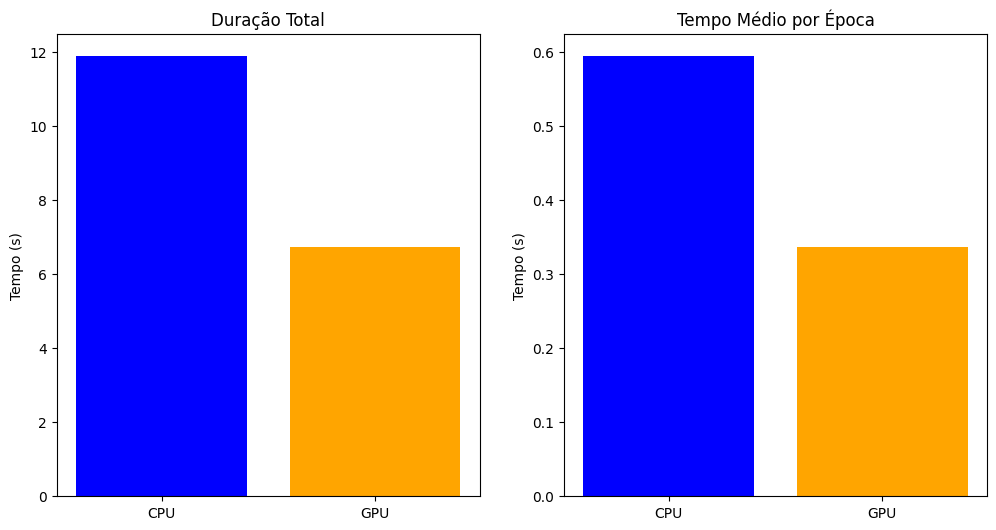

In [77]:
labels = ['CPU', 'GPU']
total_times = [sum(epoch_times_cpu), sum(epoch_times_gpu)]
mean_times = [np.mean(epoch_times_cpu), np.mean(epoch_times_gpu)]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].bar(labels, total_times, color=['blue', 'orange'])
axs[0].set_title('Duração Total')
axs[0].set_ylabel('Tempo (s)')

axs[1].bar(labels, mean_times, color=['blue', 'orange'])
axs[1].set_title('Tempo Médio por Época')
axs[1].set_ylabel('Tempo (s)')

plt.show()

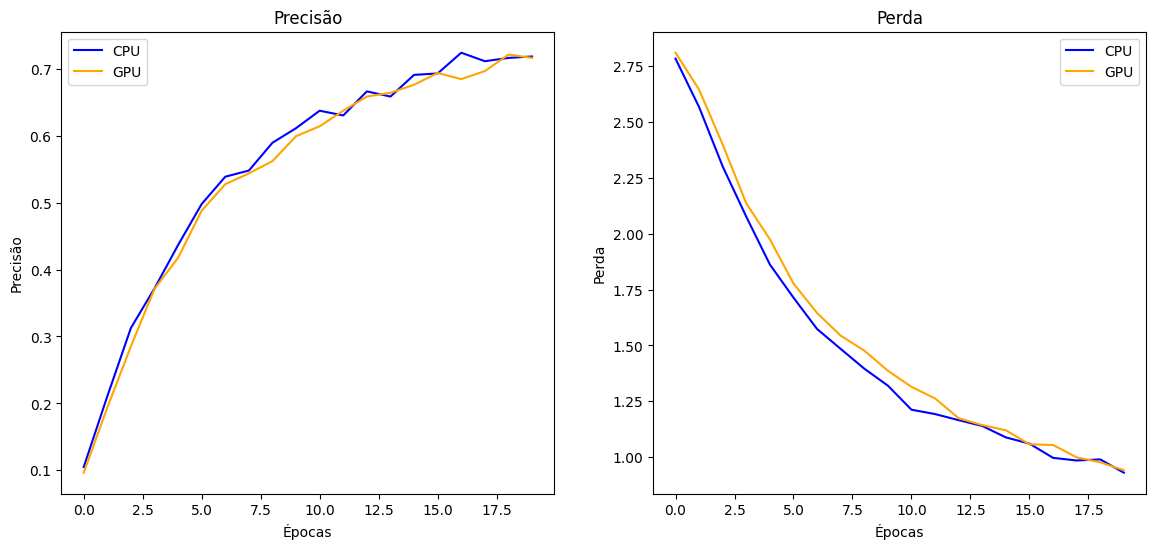

In [78]:
epochs = range(len(history_cpu.history['accuracy']))  # Supondo que você tenha históricos de época

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_cpu.history['accuracy'], label='CPU', color='blue')
plt.plot(epochs, history_gpu.history['accuracy'], label='GPU', color='orange')
plt.title('Precisão')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history_cpu.history['loss'], label='CPU', color='blue')
plt.plot(epochs, history_gpu.history['loss'], label='GPU', color='orange')
plt.title('Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()

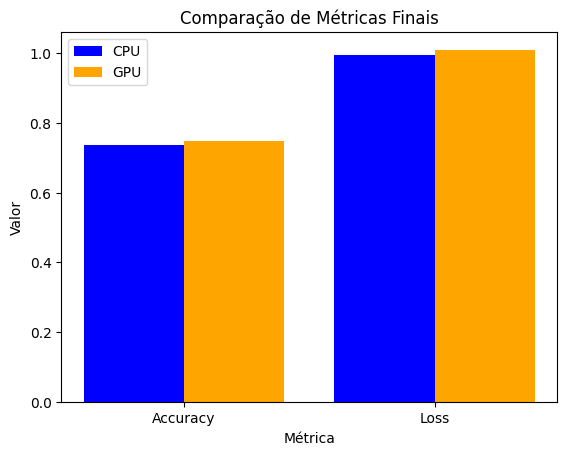

In [79]:
metrics = ['Accuracy', 'Loss']
cpu_values = [acc_cpu, loss_cpu]
gpu_values = [acc_gpu, loss_gpu]

x = range(len(metrics))

plt.bar(x, cpu_values, width=0.4, label='CPU', color='blue', align='center')
plt.bar([p + 0.4 for p in x], gpu_values, width=0.4, label='GPU', color='orange', align='center')

plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.title('Comparação de Métricas Finais')
plt.xticks([p + 0.2 for p in x], metrics)
plt.legend()

plt.show()